# Why this tutorial?
* TensorFlow has been "good but messy"
* Its been adding higher-level APIs
* A lot of documentation and tutorials out there still use lower-level APIs
* While basic should serve as a basis to create a real project
* Created with some of the best practices (suggestions and pull requests are welcome).
* The new APIs are GOOD

In [ ]:
#! pip install tensorflow-probability dm-sonnet idx2numpy dataget

In [16]:
%matplotlib inline 

import dataget as dg
import sonnet as snt
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cytoolz as cz
from dicto import dicto

sess = tf.InteractiveSession()
params = dicto.load_("parameters.yml")

/home/cristian/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# The APIs
Tensorflow includes 2 new APIs that help with a lot of common task and ensure good practices:
* Dataset API: used for ETL purposes
* Estimator API: helps with the common tasks of traning, evalauating and doing inference. Includes lots of tensorflow best practices.

![estimator_architecture](https://cdn-images-1.medium.com/max/1600/1*zoNZvvuJb06yAghetc6BfQ.png)

The Estimator API makes us implement a couple of functions:
* `train_input_fn`
* `test_input_fn`
* `model_fn`

Although you could fuse the input functions into a single function it you structure you code well. For more information I recommend these resouces:
* [Higher-Level APIs in TensorFlow](https://medium.com/onfido-tech/higher-level-apis-in-tensorflow-67bfb602e6c0)
* [Introduction to TensorFlow Datasets and Estimators](https://developers.googleblog.com/2017/09/introducing-tensorflow-datasets.html)

## Dataget
To download and import the MNIST dataset we will use `dataget` here but you can import the mnist however you want, there are various ways to import the mnist like using keras sample datasets. The first time you run this code `dataget` will download, extract, and transform the `MNIST` to jpg images; any subsequent calls use the cached data. 

In [33]:
df = dg.data("mnist").get().df # use .get(rm = True) is something fails

df.sample(10)

,class_id,filename
28402,1,/home/cristian/.dataget/data/mnist/1/train-238...
30677,1,/home/cristian/.dataget/data/mnist/1/train-109...
15827,5,/home/cristian/.dataget/data/mnist/5/train-579...
68500,0,/home/cristian/.dataget/data/mnist/0/train-188...
22816,3,/home/cristian/.dataget/data/mnist/3/train-148...
57069,7,/home/cristian/.dataget/data/mnist/7/train-383...
12219,2,/home/cristian/.dataget/data/mnist/2/train-285...
34373,1,/home/cristian/.dataget/data/mnist/1/train-117...
9110,2,/home/cristian/.dataget/data/mnist/2/train-419...
9905,2,/home/cristian/.dataget/data/mnist/2/train-391...


Dataget's `df` property give us the dataset as a pandas dataframe. The images are not loaded, it give us the absolute path of the image in the `filename` column and the corresping label in the `class_id` column. We will use TensorFlow to load the images.

## Input
The first thing we will do is create an input pipeline by implementing the `input_fn` function. This function will take a dataframe, the parameters, the training mode, and return a dictionary of feature tensors. Here we will heavily rely on the `Dataset` class in the `tf.data` module. It has many useful function to transform and filter data like:
* `map`
* `filter`
* `flat_map`
* `take`
* `skip`
* etc

as well as methods to load data. 

Concretely our input function should take no arguments and return a`features` object, which can be a single tensor or a structure of tensors, and a`labels` tensor. We will create a function that accepts parameters and turn it into a parameter-less function by using a lambda later.

In [34]:
def input_fn(df, params, mode):

    # create the dataset from numpy arrays
    ds = tf.data.Dataset.from_tensor_slices(dict(
        filename = df.filename.as_matrix(), 
        class_id = df.class_id.as_matrix(),
    ))
    
    # helper function to read the data from a file
    def parse(row):

        img = tf.read_file(row["filename"])
        img = tf.image.decode_jpeg(img, channels = 1)
        img = tf.image.resize_images(img, params.img_shape)

        row["image"] = img
        
        return row

    # read the images
    ds = ds.map(parse, num_parallel_calls=6)
    
    
    # if training, shuffle, batch, and repeat for n epochs
    if mode == tf.estimator.ModeKeys.TRAIN:
        ds = ds.shuffle(buffer_size = params.buffer_size)
        
    ds = ds.repeat(params.epochs)
    ds = ds.batch(params.batch_size, drop_remainder=False)
    
    # use prefetching to optimize training speed by getting data concurrently
    # while the gpu performs training
    ds = ds.prefetch(1)

    return ds

Before testing our input pipeline we have to shuffle and split the data properly into training and testing. We can use dataget for this purpose.

In [35]:
df = dg.shuffle(df)
df_train, df_test = dg.split(df, 0.8)

df_train.sample(10)

,class_id,filename
32041,1,/home/cristian/.dataget/data/mnist/1/train-530...
12111,2,/home/cristian/.dataget/data/mnist/2/test-2572...
29307,1,/home/cristian/.dataget/data/mnist/1/train-446...
33248,1,/home/cristian/.dataget/data/mnist/1/train-570...
34199,1,/home/cristian/.dataget/data/mnist/1/train-114...
32915,1,/home/cristian/.dataget/data/mnist/1/train-282...
54935,4,/home/cristian/.dataget/data/mnist/4/train-210...
39881,9,/home/cristian/.dataget/data/mnist/9/train-456...
14267,5,/home/cristian/.dataget/data/mnist/5/train-450...
44217,6,/home/cristian/.dataget/data/mnist/6/train-256...


Now lets call our input function to get tensor operations that will iterate through our dataset.

In [37]:
ds = input_fn(df_train, params, tf.estimator.ModeKeys.TRAIN)

# get iterator and feature tensors
iterator = ds.make_one_shot_iterator()
features = iterator.get_next()

for name, tensor in features.items():
    print("{}: {}".format(name, tensor))

filename: Tensor("IteratorGetNext_7:1", shape=(?,), dtype=string)
class_id: Tensor("IteratorGetNext_7:0", shape=(?,), dtype=int64)
image: Tensor("IteratorGetNext_7:2", shape=(?, 28, 28, 1), dtype=float32)


/home/cristian/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/cristian/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Notice that they have a fixed batch size, but most importantly they are not placeholders! This is a little different from the common (naive?) way of feading data through `feed_dict` and you can do tons of optimizations.

Now lets get a single batch of data by running our tensors. We will visualize the images using matplotlib.

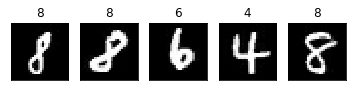

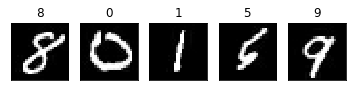

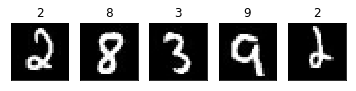

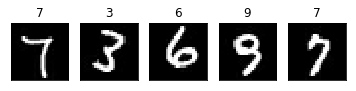

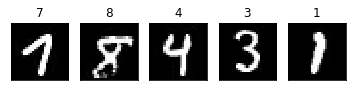

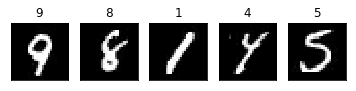

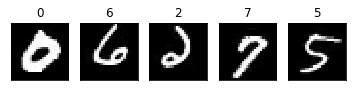

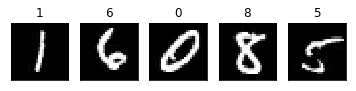

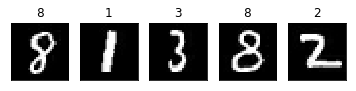

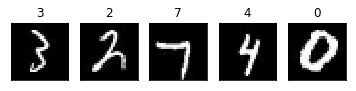

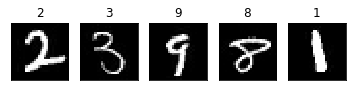

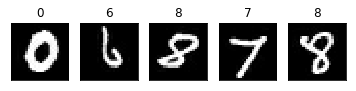

In [38]:
image = features["image"]
class_id = features["class_id"]
    
images, class_ids = sess.run([image, class_id])

for tup in cz.partition(5, zip(images, class_ids)):

    fig, axes = plt.subplots(1, 5, subplot_kw=dict())

    for i, (img, class_id) in enumerate(tup):


        img = np.squeeze(img).astype(np.uint8)

        axes[i].imshow(img, cmap="gray")
        axes[i].title.set_text(class_id)
        axes[i].get_yaxis().set_visible(False)
        axes[i].get_xaxis().set_visible(False)



plt.show()

### Model Architecture
The model architecture is arguably the most fun part of doing Deep Learning, also the part one less spends time coding. While it is not required by the Estimator API, its a good practice to split the code from the Neural Network architecture from the rest of the code and, if possible, make the architecture reusable. We get both of these benefits by using [sonnet](https://github.com/deepmind/sonnet) which is Deep Mind's library that helps you create reusable structures.

More precisely  we will be creating a small [All Convolutional Neural Network](https://arxiv.org/abs/1412.6806) with the following structure:

* Conv2D: 16 filters, kernel 4x4, stride 2, padding same, relu activation, batch normalization.
* Conv2D: 32 filters, kernel 4x4, stride 2, padding same, relu activation, batch normalization.
* Conv2D: 64 filters, kernel 3x3, stride 1, padding valid, relu activation, batch normalization.
* Conv2D: 10 filters, kernel 3x3, stride 1, padding valid, relu activation.
* Global Average Pooling
* Softmax Activation

#### Sonnet
Using sonnet is easy, we just have to create a class that inherits from `sonnet.AbstractModule` and implement it `_build` method. `_build` takes an inputs object containing the inputs tensors, constructs the main graph of the neural network, and returns an output structure of tensors.

In [48]:
class AllCNNN(snt.AbstractModule):
    
    def __init__(self, *args, **kwargs):
        kwargs["name"] = kwargs.get("name", "AllCNN")
        super(AllCNNN, self).__init__(*args, **kwargs)
    
    def _build(self, inputs):
        
        print("##########################")
        print("## AllCNN")
        print("##########################")
        
        net = inputs["image"]; print(net)
        training = inputs["mode"] == tf.estimator.ModeKeys.TRAIN
        
        
        net = tf.layers.conv2d(net, 16, [4, 4], strides=2, padding="same")
        net = tf.layers.batch_normalization(net, training=training)
        net = tf.nn.relu(net)
        print(net)
        
        
        net = tf.layers.conv2d(net, 32, [4, 4], strides=2, padding="same")
        net = tf.layers.batch_normalization(net, training=training)
        net = tf.nn.relu(net)
        print(net)
        
        
        net = tf.layers.conv2d(net, 64, [3, 3], strides=1, padding="valid")
        net = tf.layers.batch_normalization(net, training=training)
        net = tf.nn.relu(net)
        print(net)
        
        
        net = tf.layers.conv2d(net, 10, [3, 3], strides=1, padding = "valid")
#         net = tf.nn.relu(net)
        print(net)
        
        # global average pooling
        logits = net = tf.reduce_mean(net, axis = [1, 2])
        print(net)
        
        # predictions
        predictions = net = tf.nn.softmax(logits)
        print(net)
    
        print("")
        
        return logits, predictions

Just to verify our architecture is correct we will create an input tensors and construct neural network using our `AllCNN` sonnet module.

In [49]:
inputs = dict(
    image = tf.keras.Input(shape=(28, 28, 1)),
    mode = tf.estimator.ModeKeys.TRAIN,
)

all_cnn = AllCNNN()
logits, predictions = all_cnn(inputs)

##########################
## AllCNN
##########################
Tensor("input_5:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("AllCNN_4/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("AllCNN_4/Relu_1:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("AllCNN_4/Relu_2:0", shape=(?, 5, 5, 64), dtype=float32)
Tensor("AllCNN_4/conv2d_3/BiasAdd:0", shape=(?, 3, 3, 10), dtype=float32)
Tensor("AllCNN_4/Mean:0", shape=(?, 10), dtype=float32)
Tensor("AllCNN_4/Softmax:0", shape=(?, 10), dtype=float32)



### The Model
Finally we can create our last piece in the estimator API, the model function. This function takes in 4 arguments:
* `features` tensor/structure from `ìnput_fn`
* `labels` tensor from `ìnput_fn`
* `mode` enum indicating the current mode (training, testing or predicting)
* `params` dict with hyperparameters and other information we might want to pass

The model function should return a `tf.estimator.EstimatorSpec` with information such as `predictions`, `loss` and `train_op`, depending on the `mode`. Our model function is going to execute the following steps:
1. Create the network architecture to get the predictions.
1. Use the predictions and labels to construct the loss.
1. Use the loss and construct the traning operation. It will use the Adam Optimizer as our algorithm to perform Stochastic Gradient Descent.

In [50]:
def model_fn(features, labels, mode, params):
    
    inputs = features
    inputs["mode"] = mode
    
    # create networks
    all_cnn = AllCNNN()
    
    # predictions
    logits, predictions = all_cnn(inputs)
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = dict(
                classes = predictions,
                image = inputs["image"],
            )
        )
    
    # loss
    labels = features["class_id"]
    onehot_labels = tf.one_hot(labels, 10)
    
    tf.losses.softmax_cross_entropy(logits = logits, onehot_labels = onehot_labels)
    
    loss = tf.losses.get_total_loss()
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            loss = loss,
            eval_metric_ops = dict(
                accuracy = tf.metrics.accuracy(
                    labels = labels,
                    predictions = tf.argmax(predictions, axis = 1)
                )
            )
        )
    
    #update
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer = tf.train.AdamOptimizer(params["learning_rate"])
        update = optimizer.minimize(loss, global_step = tf.train.get_global_step())
        
    
    accuracy = tf.contrib.metrics.accuracy(
        labels = labels,
        predictions = tf.argmax(predictions, axis = 1)
    )
        
    # metrics
    tf.summary.scalar("accuracy", accuracy)
    
    
    return tf.estimator.EstimatorSpec(
        mode = mode,
        loss = loss,
        train_op = update,
        training_hooks = [
            tf.train.LoggingTensorHook(
                dict(
                    loss = loss, 
                    accuracy = accuracy
                ),  
                every_n_iter = 50,
            )
        ],
    )

## Estimator
Now that we have all of our functions creating the Estimator object is quite easy. We just pass it the `model_fn`, a directory were we want to store our model, the params object. Here we additionally pass a `RunConfig` object to control the frequency of checkpoints and summaries.

In [51]:
estimator = tf.estimator.Estimator(
    model_fn = model_fn,
    model_dir = params.model_dir,
    params = params,
    config = tf.estimator.RunConfig(
        save_checkpoints_steps = params.checkpoint_steps, 
        save_summary_steps = params.summary_steps,
    )
)

INFO:tensorflow:Using config: {'_model_dir': 'models/all_cnn', '_tf_random_seed': None, '_save_summary_steps': 50, '_save_checkpoints_steps': 50, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb1d82b6860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


The estimator object by itself doesn't do anything but it contains the `train`, `evaluate` and `predict` methods which will do all the hard work. 

#### Train
The `train` method accepts a parameterless `input_fn`, since our `input_fn` has parameters, we will just create a parameterless lambda that return our `input_fn` applied to the corresponding training parameters capture by the *closure* of the labmda. Excecuting this method will infact train our network!

In [53]:
estimator.train(
    input_fn = lambda: input_fn(
        df_train, 
        params,
        tf.estimator.ModeKeys.TRAIN,
    )
)

INFO:tensorflow:Calling model_fn.


/home/cristian/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


##########################
## AllCNN
##########################
Tensor("IteratorGetNext:2", shape=(?, 28, 28, 1), dtype=float32)
Tensor("AllCNN/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("AllCNN/Relu_1:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("AllCNN/Relu_2:0", shape=(?, 5, 5, 64), dtype=float32)
Tensor("AllCNN/conv2d_3/BiasAdd:0", shape=(?, 3, 3, 10), dtype=float32)
Tensor("AllCNN/Mean:0", shape=(?, 10), dtype=float32)
Tensor("AllCNN/Softmax:0", shape=(?, 10), dtype=float32)

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/all_cnn/model.ckpt-5400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5400 into models/all_cnn/model.ckpt.
INFO:tensorflow:loss = 0.00210655, step = 5400
INFO:tensorflow:accuracy = 1.0, loss = 0.00210655
INFO:tensorflow:Saving checkpoints for 5450 into mod

KeyboardInterrupt: 

#### Evaluate
To get some metrics about our models performance we will just use the `evaluate` method which also accepts a parameterless `input_fn`, we will also give it a lambda but this time we will pass the test dataset and change the mode to `EVAL`.

`evaluate` will return the computed values of `eval_metric_ops` we gave to the `EstimatorSpec` in the `EVAL` model. 

In [54]:
metrics = estimator.evaluate(
    input_fn = lambda: input_fn(
        df_test, 
        params,
        tf.estimator.ModeKeys.EVAL,
    )
)

metrics

INFO:tensorflow:Calling model_fn.


/home/cristian/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


##########################
## AllCNN
##########################
Tensor("IteratorGetNext:2", shape=(?, 28, 28, 1), dtype=float32)
Tensor("AllCNN/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("AllCNN/Relu_1:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("AllCNN/Relu_2:0", shape=(?, 5, 5, 64), dtype=float32)
Tensor("AllCNN/conv2d_3/BiasAdd:0", shape=(?, 3, 3, 10), dtype=float32)
Tensor("AllCNN/Mean:0", shape=(?, 10), dtype=float32)
Tensor("AllCNN/Softmax:0", shape=(?, 10), dtype=float32)

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-20-22:51:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/all_cnn/model.ckpt-8200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-20-22:51:28
INFO:tensorflow:Saving dict for global step 8200: accuracy = 0.986286, global_step = 8200, loss = 0.0421019
INFO:tensorflow:Saving 'checkpoint_path' su

{'accuracy': 0.98628569, 'global_step': 8200, 'loss': 0.042101901}

#### Predict
Similar to the previous methods, `predict` take the `input_fn` function but returns an iterator of the predictions for us to evaluate one by one. Firt we will just create the iterator

In [55]:
iterator = estimator.predict(
    input_fn = lambda: input_fn(
        df_test,
        params,
        tf.estimator.ModeKeys.PREDICT,
    )
)

and to end this tutorial we will perform inference some images from the test set and visualize the results! The number on top of the image is the predicted class (which should usually match), you can repeatedly run this cell to get different results.

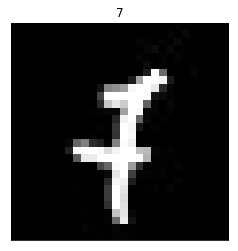

In [82]:
predictions = next(iterator)

img = predictions["image"]
class_id = np.argmax(predictions["classes"])

ax = plt.axes()

plt.imshow(img[:, :, 0], cmap="gray")

ax.title.set_text(class_id)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()